In [1]:
import sys, os
import json, pickle
import matplotlib.pyplot as plt
import matplotlib as mpl
import numpy as np
import pandas as pd
import time as pytime
import statsmodels.tsa.stattools as tsas
import ruptures as rpt
sys.path.append('../..')
import InsanallyLabEphysTools as ilep
from scipy.stats import gaussian_kde, sem, ttest_ind, ttest_rel, norm, mannwhitneyu, linregress, wilcoxon, pearsonr
from tqdm import tqdm
from types import SimpleNamespace
from sklearn import linear_model
from sklearn.model_selection import KFold
import seaborn as sns
import traceback
from itertools import product
from brokenaxes import brokenaxes
import pingouin as pg
import colorsys

plt.rcParams['legend.fontsize'] = 'small'
plt.rcParams['axes.labelsize'] = 'medium'
plt.rcParams['axes.formatter.limits'] = [-2,3]
plt.rcParams['axes.formatter.use_mathtext'] = True
plt.rcParams['axes.spines.top'] = False
plt.rcParams['axes.spines.right'] = False
plt.rcParams['xtick.direction'] = 'in'
plt.rcParams['ytick.direction'] = 'in'
plt.rcParams['figure.dpi'] = '150'

#Set global font parameters
plt.rcParams['font.family'] = 'sans-serif'
plt.rcParams['font.sans-serif'] = 'Arial'
#Set font type to TrueType for compatibility
plt.rcParams['pdf.fonttype'] = 42
plt.rcParams['ps.fonttype'] = 42

TARGET_COLOR = '#ff3654'
NONTARGET_COLOR = '#5776ff'

CR_COLOR = '#808080'
NCR_COLOR = '#FF767C'
CNO_COLOR = '#00BFFF'
SWITCH_COLOR = '#B07A3B'
LASER_COLOR = '#3375E9'
GOOD_GREY = '#969696'
GOOD_GREEN = '#32A852'
NCR_COLOR_DESAT = '#D98C90'
CR_COLOR_DESAT = '#A0A0A0'
NCR_CR_cmap = mpl.colors.LinearSegmentedColormap.from_list('NCR-CR color map', [NCR_COLOR, CR_COLOR], N=1000)
#PHASE_COLORS = ['#DEB9E0','#B78AB9','#906D92','#ABC5E8','#869BB7','#5E6C80']#,'#6ded94','#50d979','#36bf5f']
PHASE_COLORS = ['#c8abc9','#C27AC5','#764979','#B9D3F7','#5181C2','#3C557A']#V3
PASSIVE_COLOR = '#4F4F4F'

dualanimalnames = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108']
danimals = ['DS_15','DS_19','DS_24','DS_27','DS_28']

retroanimals = ['PB_86','BS_86','PB_92','BS_92','BS_100','BS_103','BS_111','BS_119','BS_123','BS_128','BS_131','BS_139','BS_163','BS_165']
did_learn = ['BS_92','BS_103','BS_111','BS_179']
did_not_learn = ['BS_86','BS_100','BS_119','BS_123','BS_128','BS_131','BS_163','BS_174']
indeterminate = ['BS_139','BS_165','BS_191','BS_192']


#BS_59
dualanimalnames = ['BS_40','BS_41','BS_42','BS_49','BS_50','BS_51','BS_56','BS_59','BS_67','BS_70','BS_72','BS_87','BS_108']#,'DS_15','DS_19']
opsinanimalnames = ['BS_86','BS_92','BS_100','BS_103','BS_111','BS_119','BS_123','BS_128','BS_131','BS_139','BS_163','BS_165','BS_174','BS_179','BS_191','BS_192']
tuninganimalnames = ['BS_173','BS_175','BS_187','BS_188','BS_213','BS_214','TH_217','AE_235','AE_236','TH_237']
unuseddualanimals = ['BS_78']
danimals = ['DS_15','DS_19','DS_24','DS_27','DS_28','DS_16','DS_17','DS_22','DS_13','DS_23']

#act_directory = 'D:\\Analysis_Cache_archived_Oct_27_2022'
act_directory = '..\\..\\Data\\Analysis_Cache'#'C:\\Users\insan\\Desktop\\Analysis_Cache_Aug23'
beh_directory = '..\\..\\Data\\Behavioor'

passivedecodingfilename = '..\\..\\Data\\stimdecoding_25s_passive.csv'
stim25sdecodingfilename = '..\\..\\Data\\stimdecoding_25s.csv'
stim25sopsinondecodingfilename = '..\\..\\Data\\stimdecoding_25s_opsin_on.csv'
stim25sopsinoffdecodingfilename = '..\\..\\Data\\stimdecoding_25s_opsin_off.csv'

current_version = 1 #June 22nd, 2023
current_version = 2 #July 11th, 2023
current_version = 3 #July 21th, 2023
current_version = 4 #July 31th, 2023
current_version = 5 #Aug 2nd, 2023
current_version = 6 #Aug 12th, 2023
current_version = 7 #Nov 6th, 2023

stdfont = 14
stdyfrac = 0.06

In [2]:
animals = np.concatenate((dualanimalnames,['DS_15','DS_19']))
# animals = ['BS_51','BS_52','BS_56','BS_59','BS_61']

In [3]:
print(animals)

['BS_40' 'BS_41' 'BS_42' 'BS_49' 'BS_50' 'BS_51' 'BS_56' 'BS_59' 'BS_67'
 'BS_70' 'BS_72' 'BS_87' 'BS_108' 'DS_15' 'DS_19']


In [4]:
animalBehaviors = ilep.getAllBehavior(beh_directory)

Fetching files for BS_51
Fetching files for BS_52
Fetching files for BS_56
Fetching files for BS_59
Fetching files for BS_61
Fetching files for BS_86
Fetching files for BS_92
Fetching files for BS_100
Fetching files for BS_103
Fetching files for BS_111
Fetching files for BS_119
Fetching files for BS_123
Fetching files for BS_128
Fetching files for BS_131
Fetching files for BS_139
Fetching files for BS_163
Fetching files for BS_165
Fetching files for BS_174
Fetching files for BS_179
Fetching files for BS_191
Fetching files for BS_192
Fetching files for BS_33
Fetching files for BS_67
Fetching files for BS_73
Fetching files for BS_78
Fetching files for BS_108
Fetching files for BS_40
Fetching files for BS_41
Fetching files for BS_42
Fetching files for BS_49
Fetching files for BS_50
Fetching files for BS_70
Fetching files for BS_72
Fetching files for BS_83
Fetching files for BS_85
Fetching files for BS_87
Fetching files for BS_95
Fetching files for BS_113
Fetching files for DS_15
Fetching 

C:\Users\4thgr\OneDrive\Documents\TothSidleck2024\Notebooks\Revisions\../..\InsanallyLabEphysTools\behavior.py:94: RuntimeWarning: invalid value encountered in scalar divide
  pc = (hit+creject)/(hit+miss+falarm+creject)
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy should be finite values
posx and posy shoul

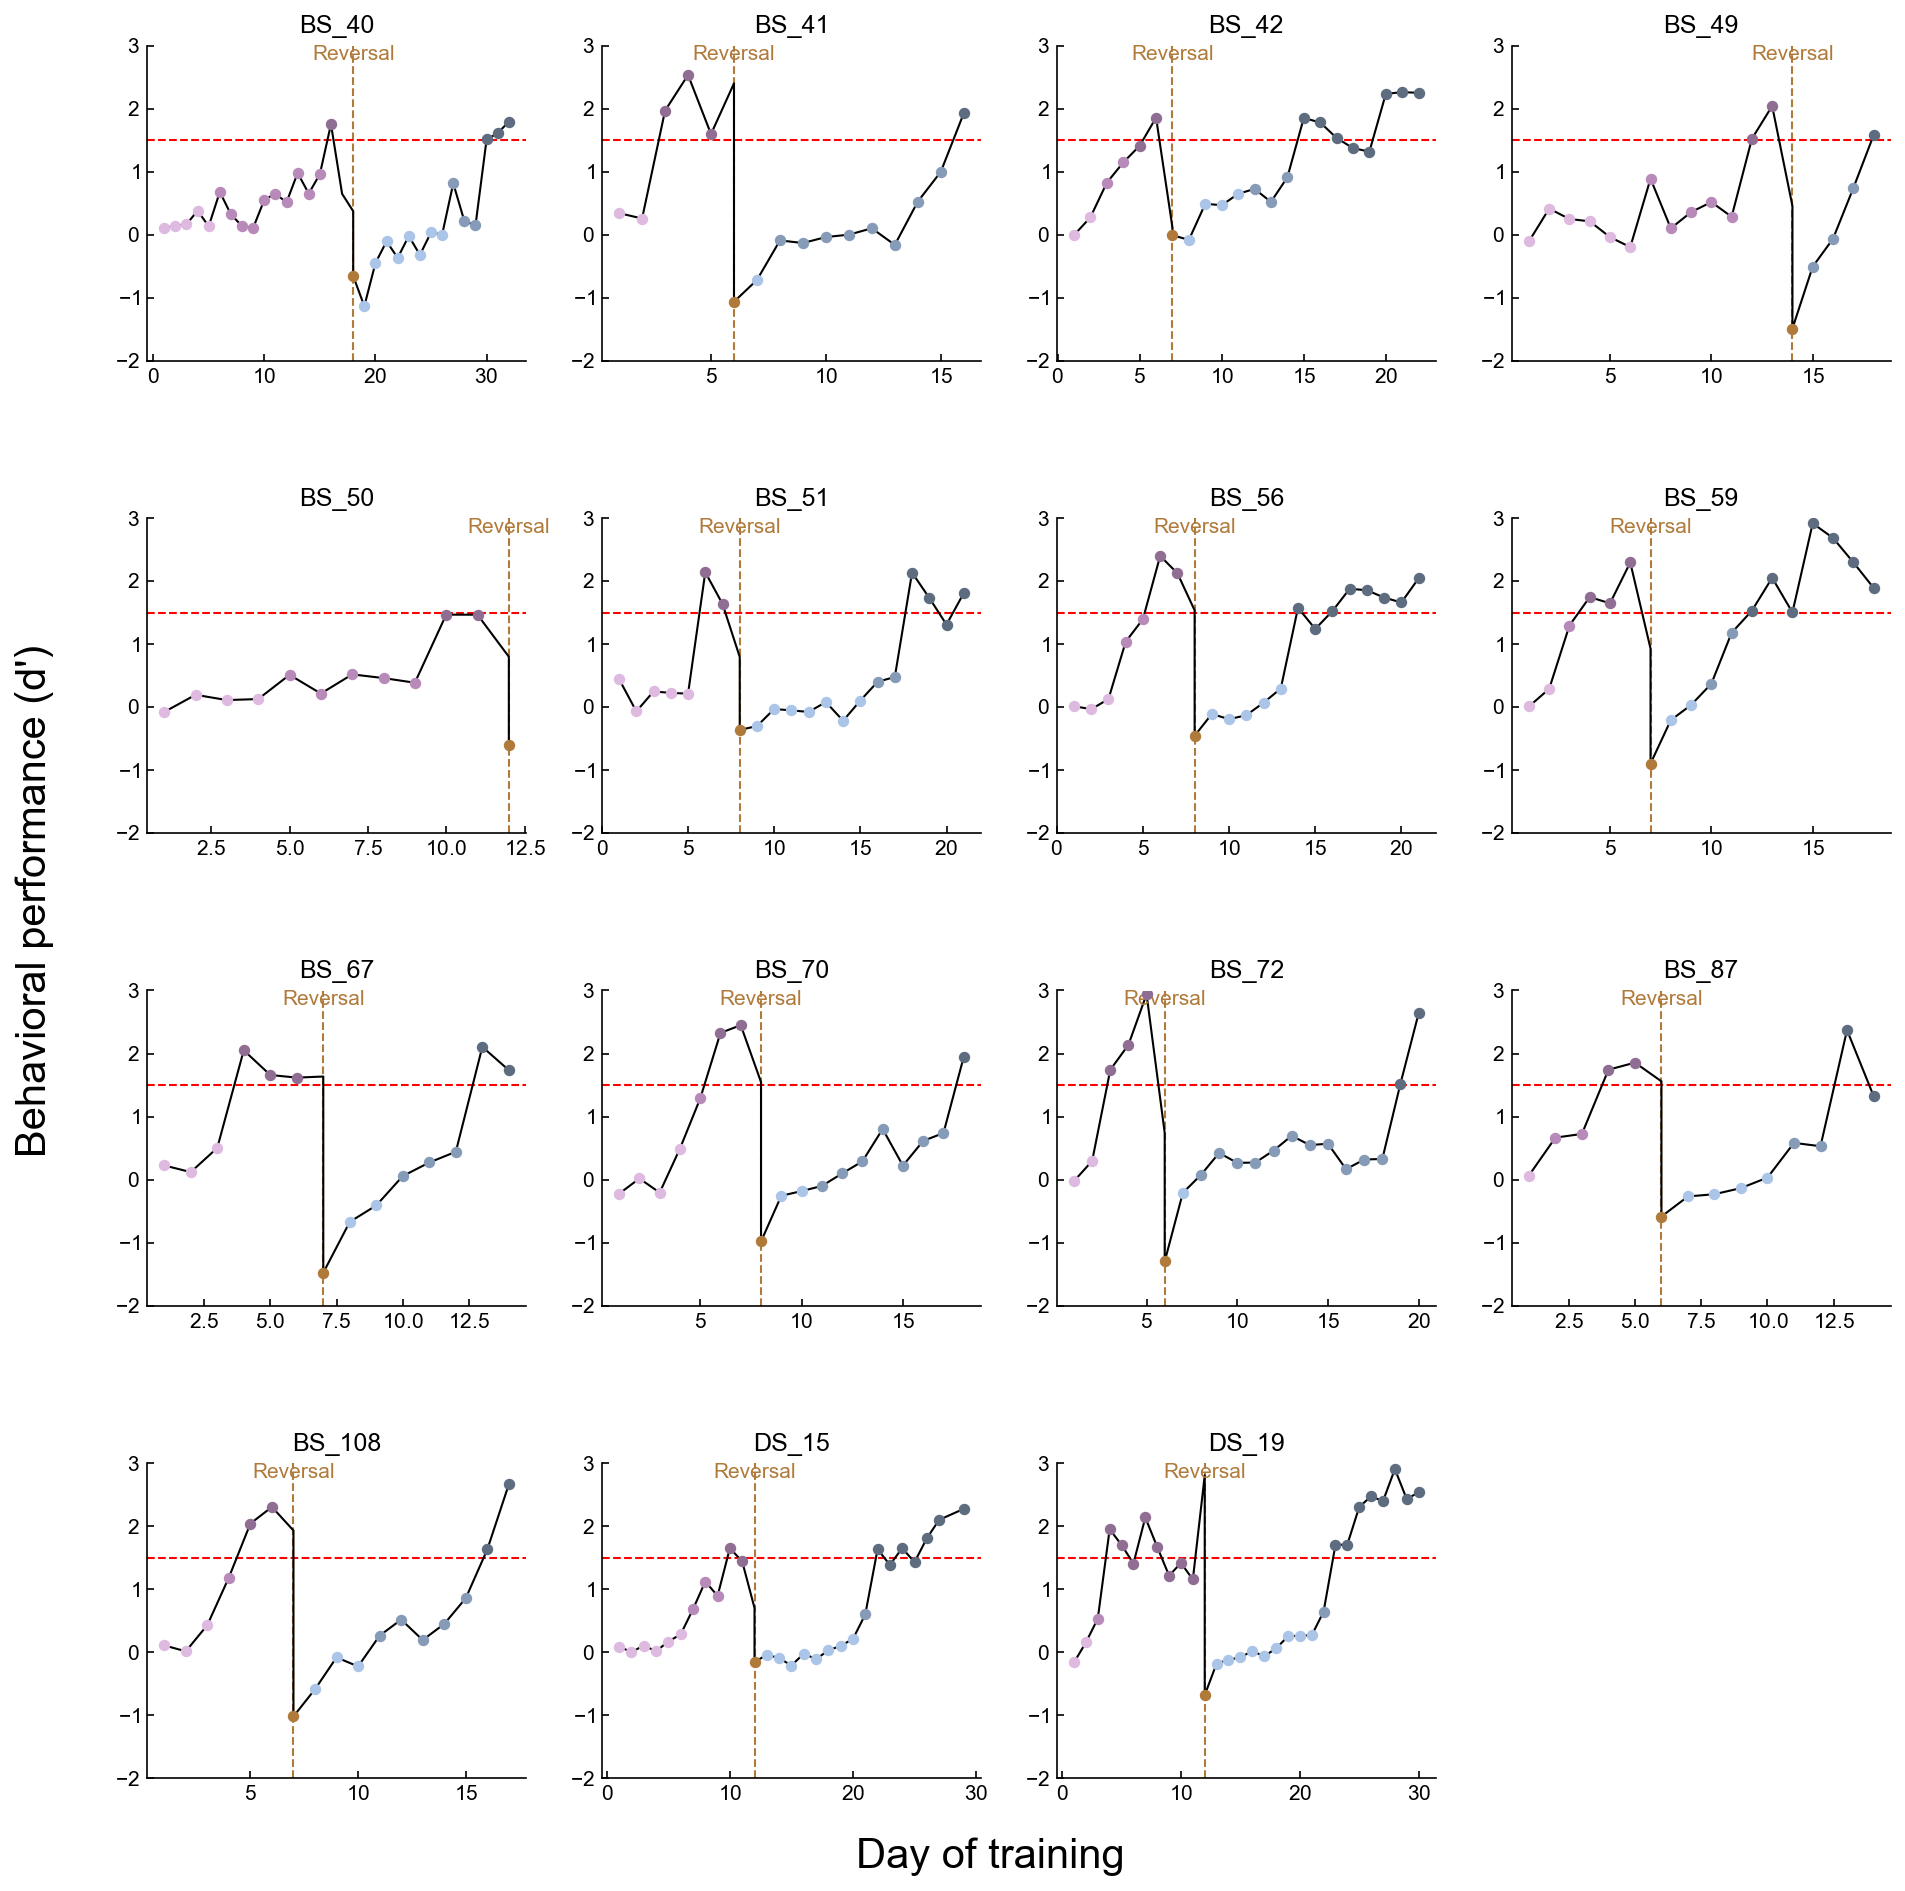

In [5]:
learning_phases,_,_ = ilep.calculateLearningPhasesV2(animals,animalBehaviors,plot=True)
#plt.savefig(os.path.join('D:\\\\TempFigures','All ephys animals learning phases.pdf'),transparent=False,facecolor="white")

In [6]:
EnumSession = []
EnumClust = []
sessions = os.listdir(act_directory)
for session in tqdm(sessions):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    if sessionfile.meta.task in ['passive no behavior']:
        continue
    if sessionfile.meta.task in ['tuning nonreversal','tuning switch','tuning reversal']:
        continue
    if sessionfile.meta.region != 'AC':
        continue
        
    if sessionfile.meta.animal not in animals:
        continue
    
    if sessionfile.meta.animal == 'BS_59':
        print('A')
    
#     EnumSession.append(session)
    for clust in sessionfile.clusters.good:
        EnumSession.append(session)
        EnumClust.append(clust)

100%|██████████| 740/740 [00:29<00:00, 24.98it/s]


In [7]:
EILphases = np.full_like(EnumSession,np.nan)
error_animals = []

for idx,session in enumerate(tqdm(EnumSession)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    try:
        animal = sessionfile.meta.animal
        day = sessionfile.meta.day_of_training
        
        if sessionfile.meta.task in ['switch','opto switch','tuning switch']:
            EILphases[idx] = 'switch'

        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and day in learning_phases[animal].pre_early_days:
            EILphases[idx] = 'pre early'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal']  and day in learning_phases[animal].pre_late_days:
            EILphases[idx] = 'pre late'
        elif sessionfile.meta.task in ['nonreversal','opto nonreversal','tuning nonreversal'] and day in learning_phases[animal].pre_expert_days:
            EILphases[idx] = 'pre expert'

        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day in learning_phases[animal].post_early_days:
            EILphases[idx] = 'post early'
        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day in learning_phases[animal].post_late_days:
            EILphases[idx] = 'post late'
        elif sessionfile.meta.task in ['reversal','opto reversal','tuning reversal']  and day in learning_phases[animal].post_expert_days:
            EILphases[idx] = 'post expert'
    except Exception as e:
        #print(ilep.generateDateString(sessionfile))
        error_animals.append(sessionfile.meta.animal)
        pass
                             
error_animals = np.unique(error_animals)
print('errors for: '+str(error_animals))

100%|██████████| 1829/1829 [00:41<00:00, 43.66it/s] 

errors for: []


# Load Decoding Data

In [8]:
stim_25s_df = pd.read_csv(stim25sdecodingfilename)
passive_df = pd.read_csv(passivedecodingfilename)
dec_df = pd.concat([stim_25s_df,passive_df])

def getDataPoint(df,session,clust,categories,column):
    df = df[df['session']==session]
    df = df[df['clust']==clust]
    df = df[df['categories']==categories]
    val = list(df[column])
    if len(val) == 1:
        return val[0]
    elif len(val) <= 0:
        return np.nan
    else:
        raise Exception('Incorrent length. Duplicate values')

In [9]:
stim_acc = []
choice_acc = []
stim_acc_c = []
choice_acc_c = []
stim_acc_s = []
choice_acc_s = []
pval_stim_s = []
pval_choice_s = []
pval_stim_c = []
pval_choice_c = []

for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
    stim_accuracy = getDataPoint(dec_df,session,clust,'stimulus','weighted_accuracy')
    choice_accuracy = getDataPoint(dec_df,session,clust,'response','weighted_accuracy')
    
    pvalue_stim_s = getDataPoint(dec_df,session,clust,'stimulus','pval_synthetic_control')
    pvalue_choice_s = getDataPoint(dec_df,session,clust,'response','pval_synthetic_control')
    
    pvalue_stim_c = 0.01#getDataPoint(dec_df,session,clust,'stimulus','pval_shuffled_control')
    pvalue_choice_c = 0.01#getDataPoint(dec_df,session,clust,'response','pval_shuffled_control')
    
    stim_acc.append(stim_accuracy)
    choice_acc.append(choice_accuracy)
    
    pval_stim_s.append(pvalue_stim_s)
    pval_choice_s.append(pvalue_choice_s)
    
    pval_stim_c.append(pvalue_stim_c)
    pval_choice_c.append(pvalue_choice_c)
    
stim_acc = np.array(stim_acc)
choice_acc = np.array(choice_acc)
pval_stim_s = np.array(pval_stim_s)
pval_choice_s = np.array(pval_choice_s)
pval_stim_c = np.array(pval_stim_c)
pval_choice_c = np.array(pval_choice_c)

1829it [00:05, 356.09it/s]


In [10]:
def get_TE_mask(acc,pval_s):#,pval_c):
    low_decoders = np.less(acc,0.5)
    low_accuracies = acc[low_decoders]
    low_magnitudes = np.absolute(low_accuracies-0.5)

    low_magnitudes = np.sort(low_magnitudes)
    task_encoder_threshold = 0.5+low_magnitudes[int(0.95 * len(low_magnitudes))]
    print('Task encoder threshold: '+str(task_encoder_threshold))

    is_finite = np.isfinite(acc)
    #is_valid_pval = np.logical_and(np.less(pval_s,0.05) , np.less(pval_c,0.05))
    is_valid_pval = np.less(pval_s,0.05)
    is_TE = np.greater_equal(acc,task_encoder_threshold)
    is_TE = np.logical_and(is_TE,is_finite)
    is_TE = np.logical_and(is_TE,is_valid_pval)
    return is_TE,task_encoder_threshold

is_TE_s,task_encoder_threshold_s = get_TE_mask(stim_acc,pval_stim_s)#,pval_stim_c)
# is_TE_c,task_encoder_threshold_c = get_TE_mask(choice_acc,pval_choice_s)#,pval_choice_c)

Task encoder threshold: 0.55951845


# Passive Data

In [11]:
animals_in_cache = []

EnumACSession = []
EnumACClust = []

for session in tqdm(os.listdir(act_directory)):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    if session in ['TH_203_1_passive_AC.pickle','TH_203_4_passive_AC.pickle','TH_203_7_passive_AC.pickle','LA_204_2_passive_AC.pickle','LA_204_3_passive_AC.pickle','LA_204_4_passive_AC.pickle']:#Outlier sessions
            continue
            
    if sessionfile.meta.animal not in ['TH_201','TH_203','LA_204','LA_205','TH_200', 'TH_230','AE_229','TH_233','TH_234','AE_294']:
        continue
#     if sessionfile.meta.animal not in ['AE_294']:
#         continue
    
    animals_in_cache.append(sessionfile.meta.animal)
    
    for clust in sessionfile.clusters.good:
        if sessionfile.meta.region == "AC":
            EnumACSession.append(session)
            EnumACClust.append(clust)
        
animals_in_cache = np.unique(animals_in_cache)

100%|██████████| 740/740 [00:10<00:00, 67.88it/s] 


In [12]:
#Define 6 learning phases(days)
pre_early = 4
pre_late = 6
pre_expert = 8
post_early = 12
post_late = 15
post_expert = 16

In [13]:
passive_stim_acc = []
passive_choice_acc = []
passive_stim_acc_c = []
passive_choice_acc_c = []
passive_stim_acc_s = []
passive_choice_acc_s = []
passive_pval_stim_s = []
passive_pval_choice_s = []
passive_pval_stim_c = []
passive_pval_choice_c = []

for idx,(session,clust) in tqdm(enumerate(zip(EnumACSession,EnumACClust))):
    passive_stim_accuracy = getDataPoint(dec_df,session,clust,'stimulus','weighted_accuracy')
    passive_choice_accuracy = getDataPoint(dec_df,session,clust,'response','weighted_accuracy')
    
    passive_pvalue_stim_s = getDataPoint(dec_df,session,clust,'stimulus','pval_synthetic_control')
    passive_pvalue_choice_s = getDataPoint(dec_df,session,clust,'response','pval_synthetic_control')
    
    passive_pvalue_stim_c = 0.01#getDataPoint(dec_df,session,clust,'stimulus','pval_shuffled_control')
    passive_pvalue_choice_c = 0.01#getDataPoint(dec_df,session,clust,'response','pval_shuffled_control')
    
    passive_stim_acc.append(passive_stim_accuracy)
    passive_choice_acc.append(passive_choice_accuracy)
    
    passive_pval_stim_s.append(passive_pvalue_stim_s)
    passive_pval_choice_s.append(passive_pvalue_choice_s)
    
    passive_pval_stim_c.append(passive_pvalue_stim_c)
    passive_pval_choice_c.append(passive_pvalue_choice_c)
    
passive_stim_acc = np.array(passive_stim_acc)
passive_choice_acc = np.array(passive_choice_acc)
passive_pval_stim_s = np.array(passive_pval_stim_s)
passive_pval_choice_s = np.array(passive_pval_choice_s)
passive_pval_stim_c = np.array(passive_pval_stim_c)
passive_pval_choice_c = np.array(passive_pval_choice_c)

is_TE_p,task_encoder_threshold_p = get_TE_mask(passive_stim_acc,passive_pval_stim_s)#,pval_stim_c)

1540it [00:04, 349.29it/s]

Task encoder threshold: 0.5634469617203128


In [14]:
cellstouseFR = 'all cells'
# cellstouseFR = 'task encoders'

animals_list = []
sessions_list = []
cluster_ID_list = []
phase_list = []
condition_list = []
FRmod_list = []
ChoiceMod_list = []

for idx,(session,clust) in tqdm(enumerate(zip(EnumSession,EnumClust))):
    sessionfile = ilep.loadSessionCached(act_directory,session)
    
    #Currently not active as tuning curve animals have not been decoded
    if cellstouseFR == 'task encoders':
        if not np.isfinite(stim_acc[idx]) or pval_stim_s[idx] > 0.05 or stim_acc[idx] < task_encoder_threshold_s:
            continue
        if np.isnan(stim_acc[idx]) or np.isnan(pval_stim_s[idx]):
            continue
    
    if EILphases[idx] not in ['pre early','pre late','pre expert','post early','post late','post expert']:
        continue

    if EILphases[idx] not in ['pre expert','post expert'] and sessionfile.meta.animal in ['DS_15','DS_19']:
        continue
        
    try:
        FRmod = sessionfile.responsiveness[clust]['all_trials'].FRmodulation
    except Exception as e:
        FRmod = np.nan
        print(e)
        
    try:
        ChoiceMod = sessionfile.responsiveness[clust]['go'].FRmodulation_choice
    except Exception as e:
        ChoiceMod = np.nan
        print(e)

    if not np.isfinite(FRmod):
        continue
    if not np.isfinite(ChoiceMod):
        continue

    animals_list.append(sessionfile.meta.animal)
    sessions_list.append(session)
    cluster_ID_list.append(clust)
    phase_list.append(EILphases[idx])
    condition_list.append('behaving')
    FRmod_list.append(FRmod)
    ChoiceMod_list.append(ChoiceMod)

1389it [00:32, 46.47it/s] 

'types.SimpleNamespace' object has no attribute 'FRmodulation_choice'
'types.SimpleNamespace' object has no attribute 'FRmodulation_choice'
'types.SimpleNamespace' object has no attribute 'FRmodulation_choice'
'types.SimpleNamespace' object has no attribute 'FRmodulation_choice'
'types.SimpleNamespace' object has no attribute 'FRmodulation_choice'
'types.SimpleNamespace' object has no attribute 'FRmodulation_choice'
'types.SimpleNamespace' object has no attribute 'FRmodulation_choice'
'types.SimpleNamespace' object has no attribute 'FRmodulation_choice'
'types.SimpleNamespace' object has no attribute 'FRmodulation_choice'
'types.SimpleNamespace' object has no attribute 'FRmodulation_choice'
'types.SimpleNamespace' object has no attribute 'FRmodulation_choice'
'types.SimpleNamespace' object has no attribute 'FRmodulation_choice'
'types.SimpleNamespace' object has no attribute 'FRmodulation_choice'
'types.SimpleNamespace' object has no attribute 'FRmodulation_choice'
'types.SimpleNamespa

1405it [00:33, 51.99it/s]

'types.SimpleNamespace' object has no attribute 'FRmodulation_choice'
'types.SimpleNamespace' object has no attribute 'FRmodulation_choice'
'types.SimpleNamespace' object has no attribute 'FRmodulation_choice'
'types.SimpleNamespace' object has no attribute 'FRmodulation_choice'
'types.SimpleNamespace' object has no attribute 'FRmodulation_choice'
'types.SimpleNamespace' object has no attribute 'FRmodulation_choice'
'types.SimpleNamespace' object has no attribute 'FRmodulation_choice'
'types.SimpleNamespace' object has no attribute 'FRmodulation_choice'
'types.SimpleNamespace' object has no attribute 'FRmodulation_choice'
'types.SimpleNamespace' object has no attribute 'FRmodulation_choice'
'types.SimpleNamespace' object has no attribute 'FRmodulation_choice'
'types.SimpleNamespace' object has no attribute 'FRmodulation_choice'


1829it [00:42, 43.45it/s]


In [15]:
df_dict = dict()
df_dict['animal'] = animals_list
df_dict['session'] = sessions_list
df_dict['cluster ID'] = cluster_ID_list
df_dict['phase'] = phase_list
df_dict['condition'] = condition_list
df_dict['FR modulation'] = FRmod_list
df_dict['Choice modulation'] = ChoiceMod_list
df = pd.DataFrame(df_dict)

In [16]:
df

,animal,session,cluster ID,phase,condition,FR modulation,Choice modulation
0,BS_108,BS_108_1_AC.pickle,2,pre expert,behaving,9.972452,3.977273
1,BS_108,BS_108_1_AC.pickle,8,pre expert,behaving,21.774194,0.486891
2,BS_108,BS_108_1_AC.pickle,9,pre expert,behaving,15.806452,10.000000
3,BS_108,BS_108_1_AC.pickle,14,pre expert,behaving,10.964187,6.969697
4,BS_108,BS_108_1_AC.pickle,34,pre expert,behaving,16.989247,12.958801
...,...,...,...,...,...,...,...
1295,DS_19,DS_19_1_AC.pickle,96,pre expert,behaving,2.546064,2.222222
1296,DS_19,DS_19_1_AC.pickle,106,pre expert,behaving,1.607565,1.285893
1297,DS_19,DS_19_20_AC.pickle,7,post expert,behaving,3.661485,6.791045
1298,DS_19,DS_19_20_AC.pickle,8,post expert,behaving,2.867012,3.407960


In [17]:
df.to_csv('..\\..\\Source Data Files\Percent NCR vs Lick Modulation.csv')

<>:1: SyntaxWarning: invalid escape sequence '\P'
<>:1: SyntaxWarning: invalid escape sequence '\P'
C:\Users\4thgr\AppData\Local\Temp\ipykernel_27888\394583485.py:1: SyntaxWarning: invalid escape sequence '\P'
  df.to_csv('..\\..\\Source Data Files\Percent NCR vs Lick Modulation.csv')


In [2]:
df = pd.read_csv('..\\..\\Source Data Files\Percent NCR vs Lick Modulation.csv')

<>:1: SyntaxWarning: invalid escape sequence '\P'
<>:1: SyntaxWarning: invalid escape sequence '\P'
C:\Users\4thgr\AppData\Local\Temp\ipykernel_18732\1191134073.py:1: SyntaxWarning: invalid escape sequence '\P'
  df = pd.read_csv('..\\..\\Source Data Files\Percent NCR vs Lick Modulation.csv')


In [3]:
np.sum(np.isfinite(df['FR modulation']))

1300

In [4]:
np.unique(df['animal'])

array(['BS_108', 'BS_40', 'BS_41', 'BS_42', 'BS_49', 'BS_50', 'BS_51',
       'BS_56', 'BS_67', 'BS_70', 'BS_72', 'BS_87', 'DS_15', 'DS_19'],
      dtype=object)

In [5]:
df_beh = df[df['condition']=='behaving']
beh_animals = np.unique(df_beh['animal'])

FR_preearly = []
FR_prelate = []
FR_preexpert = []
FR_postearly = []
FR_postlate = []
FR_postexpert = []
for animal in beh_animals:
    preearly_animal = []
    prelate_animal = []
    preexpert_animal = []
    postearly_animal = []
    postlate_animal = []
    postexpert_animal = []
    for row in df_beh.iloc():
        if row['animal'] != animal:
            continue
        if row['phase'] == 'pre early':
            preearly_animal.append(row['FR modulation'])
        if row['phase'] == 'pre late':
            prelate_animal.append(row['FR modulation'])
        if row['phase'] == 'pre expert':
            preexpert_animal.append(row['FR modulation'])
        if row['phase'] == 'post early':
            postearly_animal.append(row['FR modulation'])
        if row['phase'] == 'post late':
            postlate_animal.append(row['FR modulation'])
        if row['phase'] == 'post expert':
            postexpert_animal.append(row['FR modulation'])
    preearly_animal = np.array(preearly_animal)
    prelate_animal = np.array(prelate_animal)
    preexpert_animal = np.array(preexpert_animal)
    postearly_animal = np.array(postearly_animal)
    postlate_animal = np.array(postlate_animal)
    postexpert_animal = np.array(postexpert_animal)
    
    FR_preearly.append(preearly_animal)
    FR_prelate.append(prelate_animal)
    FR_preexpert.append(preexpert_animal)
    FR_postearly.append(postearly_animal)
    FR_postlate.append(postlate_animal)
    FR_postexpert.append(postexpert_animal)

In [6]:
mean_pc_NCR = []
sem_pc_NCR = []
for FRmods in [FR_preearly,FR_prelate,FR_preexpert,FR_postearly,FR_postlate,FR_postexpert]:
    Mw,SEMw = ilep.bootstrap_Mw_SEMw(FRmods,n_frac=1,CR_NCR_thresh=3.5)
    mean_pc_NCR.append(Mw)
    sem_pc_NCR.append(SEMw)

In [7]:
ChoiceMod_preearly = []
ChoiceMod_prelate = []
ChoiceMod_preexpert = []
ChoiceMod_postearly = []
ChoiceMod_postlate = []
ChoiceMod_postexpert = []

for row in df.iloc:
    if row['phase'] == 'pre early':
        ChoiceMod_preearly.append(row['Choice modulation'])
    if row['phase'] == 'pre late':
        ChoiceMod_prelate.append(row['Choice modulation'])
    if row['phase'] == 'pre expert':
        ChoiceMod_preexpert.append(row['Choice modulation'])
        
    if row['phase'] == 'post early':
        ChoiceMod_postearly.append(row['Choice modulation'])
    if row['phase'] == 'post late':
        ChoiceMod_postlate.append(row['Choice modulation'])
    if row['phase'] == 'post expert':
        ChoiceMod_postexpert.append(row['Choice modulation'])

ChoiceMod_preearly = np.array(ChoiceMod_preearly)
ChoiceMod_prelate = np.array(ChoiceMod_prelate)
ChoiceMod_preexpert = np.array(ChoiceMod_preexpert)
ChoiceMod_postearly = np.array(ChoiceMod_postearly)
ChoiceMod_postlate = np.array(ChoiceMod_postlate)
ChoiceMod_postexpert = np.array(ChoiceMod_postexpert)

In [8]:
print('loaded')

loaded


[2.4245121015359734, 2.6352876414615967, 3.3605910235210104, 2.591927615942431, 1.9558674218618268, 3.1479434453562534]


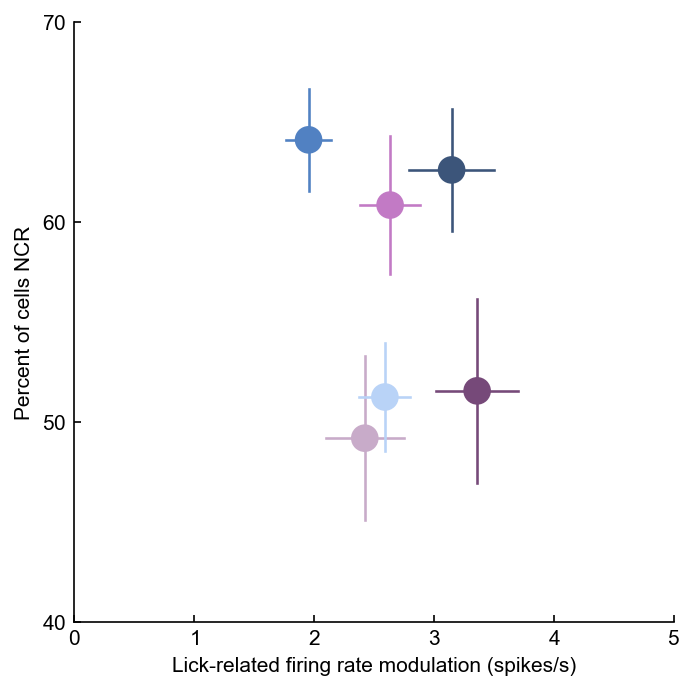

In [10]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

def statsbar(ax,barheight,xpoints,stemheights,text=None,lw=1):
    ymax = ax.get_ylim()[1]
    ymin = ax.get_ylim()[0]
    yrange = ymax-ymin
    ydist = 0.025*yrange
    
    ax.plot([xpoints[0]]*2,[stemheights[0]+ydist,barheight],lw=lw,color='k')
    ax.plot([xpoints[1]]*2,[stemheights[1]+ydist,barheight],lw=lw,color='k')
    ax.plot(xpoints,[barheight]*2,lw=lw,color='k')
    
    if not text is None:
        ax.text(np.mean(xpoints),barheight + ydist,text,horizontalalignment='center',verticalalignment='center')

fig,ax = make_axis_size(4, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.2

################################################################################################################

wid = 0.175

percent_NCR = mean_pc_NCR
sem_NCR = sem_pc_NCR
Choice_FRmod = [np.mean(x) for x in [ChoiceMod_preearly,ChoiceMod_prelate,ChoiceMod_preexpert,ChoiceMod_postearly,ChoiceMod_postlate,ChoiceMod_postexpert]]
sem_Choice_FRmod = [sem(x) for x in [ChoiceMod_preearly,ChoiceMod_prelate,ChoiceMod_preexpert,ChoiceMod_postearly,ChoiceMod_postlate,ChoiceMod_postexpert]]
print(Choice_FRmod)

ax.scatter(Choice_FRmod,percent_NCR,c=PHASE_COLORS,s=150)
for idx in range(6):
    ax.plot([Choice_FRmod[idx]-sem_Choice_FRmod[idx],Choice_FRmod[idx]+sem_Choice_FRmod[idx]],[percent_NCR[idx]]*2,color=PHASE_COLORS[idx],lw=1.25)
    ax.plot([Choice_FRmod[idx]]*2,[percent_NCR[idx]-sem_NCR[idx],percent_NCR[idx]+sem_NCR[idx]],color=PHASE_COLORS[idx],lw=1.25)
    # ax.scatter([idx+wid+p*switch_offset],(mean_pc_NCR[idx]),c=PHASE_COLORS[idx],s=150,zorder=10,marker='o',lw=1.25)
    # ax.plot([idx+wid+p*switch_offset,idx+wid+p*switch_offset],[(mean_pc_NCR[idx]-sem_pc_NCR[idx]),(mean_pc_NCR[idx]+sem_pc_NCR[idx])],color=PHASE_COLORS[idx],lw=1.25,zorder=9)
    
################################################################################################################

labels = ['Early','Late','Expert','Early','Late','Expert']
labels2 = [1,2,3,4,5,6]

ylab = ax.set_ylabel('Percent of cells NCR')
ax.set_ylim([40,70])
ax.set_yticks([40,50,60,70])

xlab = ax.set_xlabel('Lick-related firing rate modulation (spikes/s)')
ax.set_xlim([0,5])
ax.set_xticks([0,1,2,3,4,5])

artists = []
fig.savefig(os.path.join('C:\\\\Users\\4thgr\\Downloads','AC percent NCR V'+str(current_version)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

[2.4245121015359734, 2.6352876414615967, 3.3605910235210104, 2.591927615942431, 1.9558674218618268, 3.1479434453562534]


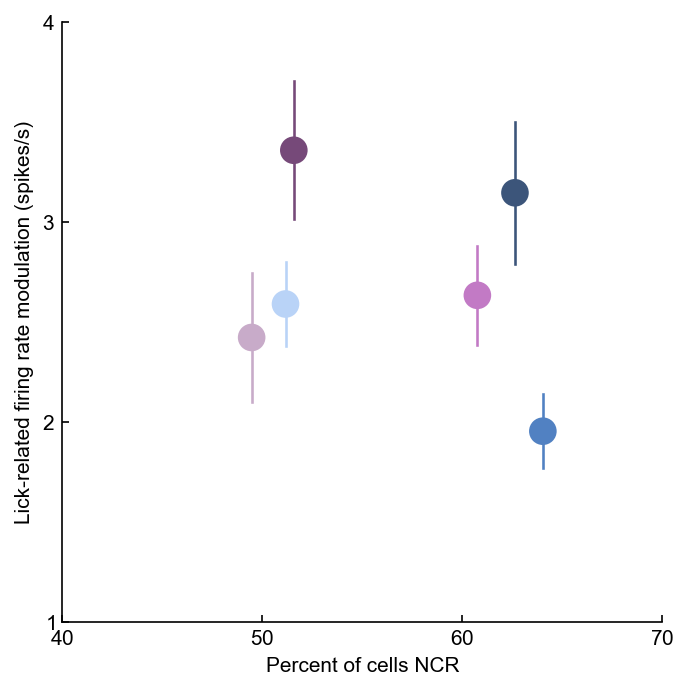

In [11]:
def add_axis_size(fig, ax_w, ax_h, left, bottom):
    fig_w, fig_h = fig.get_size_inches()
    ax = fig.add_axes([left/fig_w, bottom/fig_h, ax_w/fig_w, ax_h/fig_h])
    return ax

def make_axis_size(ax_w, ax_h, left=.3, bottom=.3, right=0, top=0):
    fig_w = (ax_w + left + right) * 1.05
    fig_h = (ax_h + bottom + top) * 1.05
    fig = plt.figure(figsize=(fig_w, fig_h))
    ax = add_axis_size(fig, ax_w, ax_h, left, bottom)
    return fig, ax

def statsbar(ax,barheight,xpoints,stemheights,text=None,lw=1):
    ymax = ax.get_ylim()[1]
    ymin = ax.get_ylim()[0]
    yrange = ymax-ymin
    ydist = 0.025*yrange
    
    ax.plot([xpoints[0]]*2,[stemheights[0]+ydist,barheight],lw=lw,color='k')
    ax.plot([xpoints[1]]*2,[stemheights[1]+ydist,barheight],lw=lw,color='k')
    ax.plot(xpoints,[barheight]*2,lw=lw,color='k')
    
    if not text is None:
        ax.text(np.mean(xpoints),barheight + ydist,text,horizontalalignment='center',verticalalignment='center')

fig,ax = make_axis_size(4, 4, left=.3, bottom=.3, right=0, top=0)
switch_offset = 0.2

################################################################################################################

wid = 0.175

percent_NCR = mean_pc_NCR
Choice_FRmod = [np.mean(x) for x in [ChoiceMod_preearly,ChoiceMod_prelate,ChoiceMod_preexpert,ChoiceMod_postearly,ChoiceMod_postlate,ChoiceMod_postexpert]]
sem_Choice_FRmod = [sem(x) for x in [ChoiceMod_preearly,ChoiceMod_prelate,ChoiceMod_preexpert,ChoiceMod_postearly,ChoiceMod_postlate,ChoiceMod_postexpert]]
print(Choice_FRmod)

ax.scatter(percent_NCR,Choice_FRmod,c=PHASE_COLORS,s=150)
for idx in range(6):
    ax.plot([percent_NCR[idx]]*2,[Choice_FRmod[idx]-sem_Choice_FRmod[idx],Choice_FRmod[idx]+sem_Choice_FRmod[idx]],color=PHASE_COLORS[idx],lw=1.25)
    
    # ax.scatter([idx+wid+p*switch_offset],(mean_pc_NCR[idx]),c=PHASE_COLORS[idx],s=150,zorder=10,marker='o',lw=1.25)
    # ax.plot([idx+wid+p*switch_offset,idx+wid+p*switch_offset],[(mean_pc_NCR[idx]-sem_pc_NCR[idx]),(mean_pc_NCR[idx]+sem_pc_NCR[idx])],color=PHASE_COLORS[idx],lw=1.25,zorder=9)
    
################################################################################################################

labels = ['Early','Late','Expert','Early','Late','Expert']
labels2 = [1,2,3,4,5,6]

xlab = ax.set_xlabel('Percent of cells NCR')
ax.set_xlim([40,70])
ax.set_xticks([40,50,60,70])

ylab = ax.set_ylabel('Lick-related firing rate modulation (spikes/s)')
ax.set_ylim([1,4])
ax.set_yticks([1,2,3,4])

artists = []
fig.savefig(os.path.join('C:\\\\Users\\4thgr\\Downloads','AC percent NCR V'+str(current_version)+'.pdf'),transparent=False,facecolor="white",dpi=400, bbox_extra_artists=(artists), bbox_inches='tight')

In [17]:
pearsonr(percent_NCR,Choice_FRmod)

PearsonRResult(statistic=-0.23277212737019792, pvalue=0.6571479391211024)